# Segmentation

We use a segmentation network to convert B-scans to layer maps.

In [1]:
import idp_utils.data_handling.constants as C
%cd $C.ROOT_PATH

import os
from pathlib import Path
from glob import glob
import random
import shutil

from PIL import Image
import imageio
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torchvision.transforms as transforms
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

/home/extra/micheal/IDP


## A Simple Segmentation Network (UNet)

### Source & Target Data

In [2]:
%load_ext tensorboard

In [2]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
    '.tif', '.TIF', '.tiff', '.TIFF',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, max_dataset_size=float("inf")):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

class ABDataset(Dataset):
    '''
    The dataset where A and B are concatenated horizontally
    '''
    def __init__(self, dataroot, phase='train', grayscale=True, A_transform=None, B_transform=None):
        self.A_transform = A_transform
        self.B_transform = B_transform
        self.grayscale = grayscale
        self.dir_AB = os.path.join(dataroot, phase)  # get the image directory
        self.AB_paths = sorted(make_dataset(self.dir_AB))  # get image paths
    
    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.AB_paths)

    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index - - a random integer for data indexing
        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # read a image given a random integer index
        AB_path = self.AB_paths[index]
        AB = Image.open(AB_path)
        if self.grayscale:
            AB = AB.convert('L')
        else:
            AB = AB.convert('RGB')
        # split AB image into A and B
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))

        # apply the same transform to both A and B
        if self.A_transform:
            A_transform = transforms.Compose(self.A_transform)
            A = A_transform(A)
        if self.B_transform:
            B_transform = transforms.Compose(self.B_transform)
            B = B_transform(B)
        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

In [3]:
AROI_LABELS = [19, 57, 171, 190]
FLUID_LABELS = [80, 160, 240]
aroi_labels = sorted([0] + AROI_LABELS + FLUID_LABELS)
print('aroi labels:', aroi_labels)
aroi_label_dict = {x : i for i, x in enumerate(aroi_labels)}

class Image2Label(object):
    def __init__(self, label_dict):
        self.label_dict = label_dict
    def __call__(self, sample):
        sample = torch.round(sample * 255).type(torch.int64)
        for k, v in self.label_dict.items():
            sample[torch.where(sample==k)] = v
        return sample  

aroi labels: [0, 19, 57, 80, 160, 171, 190, 240]


In [4]:
# A is label map, B is b-scan. In segmentation, A will be the target. 
train_dataset = ABDataset(dataroot='data/datasets/AROI/original',
                    phase='train',
                    A_transform=[transforms.ToTensor(), Image2Label(aroi_label_dict)],
                    B_transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
val_dataset = ABDataset(dataroot='data/datasets/AROI/original',
                    phase='val',
                    A_transform=[transforms.ToTensor(), Image2Label(aroi_label_dict)],
                    B_transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Let's visualize a sample:

Text(0.5, 1.0, 'B')

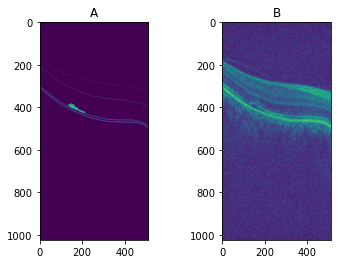

In [21]:
sample = train_dataset[2]
fig, axis = plt.subplots(1, 2)
axis[0].imshow(sample['A'].permute(1,2,0))
axis[0].set_title('A')
axis[1].imshow(sample['B'].permute(1,2,0))
axis[1].set_title('B')

In [5]:
sample['A'].shape

torch.Size([1, 1024, 512])

### Define Model

In [6]:
# unet = smp.Unet('resnet34', in_channels=1, classes=8)

In [13]:
unet = smp.Unet(
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=8,                      # model output channels (number of classes in your dataset)
    encoder_depth=3,                # Amount of down- and upsampling of the Unet
    decoder_channels=(64, 32,16),   # Amount of channels
    encoder_weights = "imagenet",         # Model does not download pretrained weights
    activation = 'sigmoid'            # Activation function to apply after final convolution       
)

In [10]:
device = torch.device('cuda')
unet.to(device)
summary(unet, input_size=(1, 1024, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 256]           3,136
       BatchNorm2d-2         [-1, 64, 512, 256]             128
              ReLU-3         [-1, 64, 512, 256]               0
         MaxPool2d-4         [-1, 64, 256, 128]               0
            Conv2d-5         [-1, 64, 256, 128]          36,864
       BatchNorm2d-6         [-1, 64, 256, 128]             128
              ReLU-7         [-1, 64, 256, 128]               0
            Conv2d-8         [-1, 64, 256, 128]          36,864
       BatchNorm2d-9         [-1, 64, 256, 128]             128
             ReLU-10         [-1, 64, 256, 128]               0
       BasicBlock-11         [-1, 64, 256, 128]               0
           Conv2d-12         [-1, 64, 256, 128]          36,864
      BatchNorm2d-13         [-1, 64, 256, 128]             128
             ReLU-14         [-1, 64, 2

### Train

In [22]:
sanity_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [12]:
# Check CUDA usability
torch.zeros((2,2)).cuda()

tensor([[0., 0.],
        [0., 0.]], device='cuda:0')

In [23]:
batch = next(iter(sanity_loader))
device = torch.device('cuda')
B = batch['B'].to(device)
A = batch['A'].to(device)
unet = unet.to(device)
# print('unique A:', torch.unique(A))

Sanity check:

In [12]:
torch.cuda.empty_cache()

In [13]:
with torch.no_grad():
    fake_A = unet(B)
print('fake A shape:', fake_A.shape)
print('A shape:', A.shape)
loss_fn = smp.losses.DiceLoss('multiclass', classes=8)
loss_fn(fake_A, A.type(torch.int64))

fake A shape: torch.Size([4, 8, 1024, 512])
A shape: torch.Size([4, 1, 1024, 512])


tensor(0.8387, device='cuda:0')

Wrap the unet in a pytorch lightining model:

In [14]:
# Install dev version of smp to use metrics
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch.git

In [13]:
class ModelWrapper(pl.LightningModule):
    def __init__(self, model, lr, loss, num_classes=None):
        super().__init__()
        self.backbone = model
        self.lr = lr
        self.loss = loss
        self.num_classes = num_classes
        self.writer = SummaryWriter()

    def forward(self, x):
        y = self.backbone(x)
        return y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def compute_metrics(self, output, target):
        # 1 is the channel dim
        output = output.argmax(dim=1)
        # restore channel dim for loss computation
        output = output.unsqueeze(dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, 'multiclass', ignore_index=-1, num_classes=self.num_classes)
        # then compute metrics with required reduction (see metric docs)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        return {
            'iou': iou_score,
            'f1': f1_score,
            'f2': f2_score,
            'accuracy': accuracy,
            'recall': recall
        }

    def training_step(self, train_batch, batch_idx):
        # Perform the forward pass, compute the loss and the metric of each step
        A = train_batch['A']
        B = train_batch['B']
        A_fake = self.forward(B)
        loss = self.loss(A_fake, A)
        metric_dict = self.compute_metrics(A_fake, A)
        metric = metric_dict['f1']
        return {"loss": loss, "metric": metric}

    def training_epoch_end(self, output):
        loss = 0
        metric = 0
        for o in output:
            # compute the loss and metric of the epoch 
            loss = loss + o['loss']
            metric = metric + o['metric']
        loss = loss / len(output)
        metric = metric / len(output)
        self.writer.add_scalar('Epoch_loss/training', loss, self.current_epoch)
        self.writer.add_scalar('Epoch_metric/training', metric, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        A = val_batch['A']
        B = val_batch['B']
        with torch.no_grad():
            A_fake = self.forward(B)
        loss = self.loss(A_fake, A)
        metric_dict = self.compute_metrics(A_fake, A)
        metric = metric_dict['f1']
        return {"loss": loss, "metric": metric}

    def validation_epoch_end(self,output):
        loss = 0
        metric = 0
        for o in output:
            # Compute the loss and metric of the epoch 
            loss = loss + o['loss']
            metric = metric + o['metric']

        loss = loss / len(output)
        metric = metric / len(output)
        self.log('val_dice', metric)
        self.writer.add_scalar('Epoch_loss/validation', loss, self.current_epoch)
        self.writer.add_scalar('Epoch_metric/validation', metric, self.current_epoch)

In [14]:
model = ModelWrapper(unet, 0.001, smp.losses.DiceLoss('multiclass', classes=8), num_classes=8)

NameError: name 'unet' is not defined

Let's first run an epoch for sanity check

In [16]:
!rm -rf runs
!mkdir runs

In [71]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_dice',
    save_top_k=3,
    mode='max',
    every_n_epochs=1,
    save_last=True
)

trainer = pl.Trainer(gpus='0', 
                     auto_select_gpus=True,
                    # precision='bf16', 
                    callbacks=checkpoint_callback,
                    check_val_every_n_epoch=1,
                    log_every_n_steps=5,
                    max_epochs=100,
                    default_root_dir="output/checkpoints/unet")
# trainer.fit(model, sanity_loader, sanity_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [72]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint("output/unet1.ckpt")
print(checkpoint_callback.best_model_path)


  | Name     | Type     | Params
--------------------------------------
0 | backbone | Unet     | 21.5 M
1 | loss     | DiceLoss | 0     
--------------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
85.922    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [3]:
%tensorboard --logdir runs

### Use the segmentation model for image back-translation

#### Test its performance
We will use the trained model to convert fake bscans to layer maps

In [15]:
# Load from checkpoint
net = smp.PSPNet(
    encoder_name = 'resnet34', 
    encoder_weights = 'imagenet',
    encoder_depth=3,
    in_channels=1,
    classes=8
)
model = ModelWrapper.load_from_checkpoint('output/checkpoints/psp1/lightning_logs/version_0/checkpoints/last.ckpt', model=net, lr=0.001, loss=smp.losses.DiceLoss('multiclass', classes=8))

Pass a image to it for result

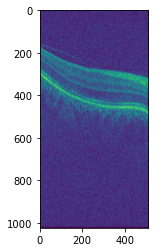

In [16]:
img_idx = 1
sample_b = train_dataset[img_idx]['B']
plt.imshow(sample_b.squeeze(0))

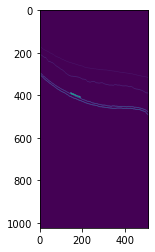

In [17]:
sample_a = train_dataset[img_idx]['A']
plt.imshow(sample_a.squeeze(0))

torch.Size([1, 8, 1024, 512])


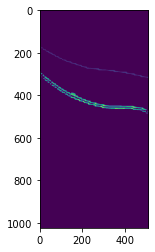

In [53]:
seg_sample = model(sample_b.unsqueeze(0))
print(seg_sample.shape)
plt.imshow(seg_sample.squeeze(0).argmax(dim=0).cpu())

#### Back-translate results

```python

    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index - - a random integer for data indexing
        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # read a image given a random integer index
        AB_path = self.AB_paths[index]
        AB = Image.open(AB_path)
        if self.grayscale:
            AB = AB.convert('L')
        else:
            AB = AB.convert('RGB')
        # split AB image into A and B
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))

        # apply the same transform to both A and B
        if self.A_transform:
            A_transform = transforms.Compose(self.A_transform)
            A = A_transform(A)
        if self.B_transform:
            B_transform = transforms.Compose(self.B_transform)
            B = B_transform(B)
        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}
```

In [18]:
filepattern = '/home/extra/micheal/IDP/results/pix2pix_aroi_original/test_latest/images/*fake_B*'
files = list(glob(filepattern))
len(files)

377

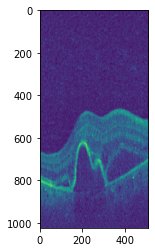

In [19]:
def image2tensor(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((1024, 512)), transforms.Normalize((0.5,), (0.5,))])
    img = transform(img)
    return img

file_idx = 2
img = image2tensor(files[file_idx])
plt.imshow(img.squeeze(0))

torch.Size([1024, 512])


array([0, 1, 3, 4, 5, 6])

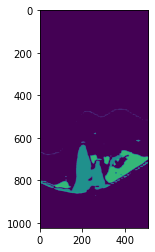

In [20]:
def backtranslate(bscan_path):
    bscan = image2tensor(bscan_path)
    seg = model(bscan.unsqueeze(0))
    segmap = seg.squeeze(0).argmax(dim=0).cpu()
    return segmap

file_idx = 2
fake_B_path = files[file_idx]
seg = backtranslate(fake_B_path)
print(seg.shape)
plt.imshow(seg)
np.unique(seg)

torch.Size([1024, 512])


array([0, 1, 2, 5, 6])

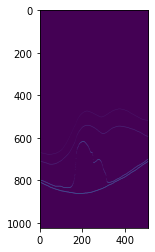

In [22]:
def fake2extract_layer_path(fake_b_path):
    remove_fake_b = ''.join(fake_b_path.split('_fake_B'))
    # remove metrics to find original path
    if 'Metric:  ' in remove_fake_b:
        remove_fake_b = remove_fake_b.split('  ')[0] + '.' + remove_fake_b.split('.')[-1]
    extract_path_trunk = 'data/extract/layers/AROI/original/'
    extract_path = extract_path_trunk + remove_fake_b.split('/')[-1]
    return extract_path

def fakeb2realseg(fake_b_path):
    real_a_path = fake2extract_layer_path(fake_b_path)
    img = Image.open(real_a_path)
    img = img.convert('L')
    transform = transforms.Compose([transforms.ToTensor(), Image2Label(aroi_label_dict)])
    img = transform(img)
    return img.squeeze(0)

real_a = fakeb2realseg(fake_B_path)
print(real_a.shape)
plt.imshow(real_a)
np.unique(real_a)

A scan

Use **dice** loss for comparison:

In [23]:
import torchmetrics

dice_score = torchmetrics.Dice(num_classes=8, ignore_index=0)

dice_score(seg, real_a)
loss = 1- dice_score(seg, real_a)
loss

tensor(0.9777)

Use **first occurance distance** as a metric

In [24]:
def detect_first_occurrence(img, num_classes=4):
    '''
    Detect edges vertically for AROI colormap. It returns edges in the shape of (width, #num_classes)
    '''
    shape = img.shape
    # It only works for numpy array
    if isinstance(img, torch.Tensor):
        img = img.numpy()
    edges = np.zeros((shape[1], num_classes), dtype=int)
    for i in range(shape[1]):
        for j in range(1, num_classes+1):
            # get the upper bound of class j
            res = np.nonzero(img[:, i] == j)
            indices = res[0]
            # if the element does not exist, log it as -1
            if len(indices) == 0:
                idx = -1
            else:
                idx = indices[0]
            edges[i][j-1] = idx
    return edges

In [33]:
def first_occurrence_loss(preds, target, num_classes):
    assert preds.shape == target.shape, f"preds and target are expected to be in the same shape. {preds.shape}!={target.shape}"
    occur_preds = detect_first_occurrence(preds, num_classes)
    occur_target = detect_first_occurrence(target, num_classes)
    loss =  np.abs((occur_target - occur_preds).sum()) / np.prod(preds.shape) / num_classes
    return loss

In [30]:
first_occurrence_loss(seg, real_a, num_classes=6)

0.009444554646809896

## Train a neural network on both: i) AROI and ii) intraoperative datasets


### Prepare Data (Use separate set of labels for those two datasets)

#### Strategy 1: Merge homo-dataset
We merge AROI and OP data into one dataset

In [ ]:
%%bash
mkdir -p data/datasets/OPAROI/original
cp -nr data/datasets/AROI/original/* data/datasets/OPAROI/original
cp -nr data/datasets/OP/original/* data/datasets/OPAROI/original

In [ ]:
%%bash
aroi_cnt=`ls data/datasets/AROI/original/*/* | wc -l`
op_cnt=`ls data/datasets/OP/original/*/* | wc -l`
oparoi_cnt=`ls data/datasets/OPAROI/original/*/* | wc -l`
echo $aroi_cnt
echo $op_cnt
echo $oparoi_cnt
if [ $oparoi_cnt==$op_cnt+$aroi_cnt ]
then
    echo "Correctly merged two datasets"
fi

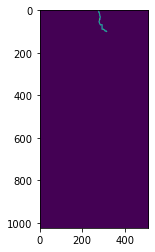

In [33]:
seg = imageio.imread('data/raw/OP/Part2/OS-2020-02-03_113721fs/segmentation/084.bmp')
plt.imshow(seg==4)

#### Strategy 1: Use same labels for the same layer

There are two layers in OP dataset that also present in AROI dataset.
```python
AROI_LABELS = [ILM, IPL_INL, RPE, BM]
OP_LABELS = [ILM, RPE]
```

In [68]:
AROI_LABELS = [19, 57, 171, 190]
OP_LABELS = [19, 171]
FLUID_LABELS = [80, 160, 240]
INSTRUMENT_LABELS = [100, 200]
oparoi_labels = [0] + AROI_LABELS + OP_LABELS + FLUID_LABELS + INSTRUMENT_LABELS
oparoi_labels = sorted(oparoi_labels)
oparoi_label_dict = {x : i for i, x in enumerate(oparoi_labels)}

In [ ]:
train_dataset = ABDataset(dataroot='data/datasets/OPAROI/original',
                    phase='train',
                    A_transform=[transforms.ToTensor(), Image2Label(oparoi_label_dict)],
                    B_transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
val_dataset = ABDataset(dataroot='data/datasets/OPAROI/original',
                    phase='val',
                    A_transform=[transforms.ToTensor(), Image2Label(oparoi_label_dict)],
                    B_transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [69]:
class Image2Label(object):
    def __init__(self, label_dict):
        self.label_dict = label_dict
    def __call__(self, sample):
        sample = torch.round(sample * 255).type(torch.int64)
        for k, v in self.label_dict.items():
            sample[torch.where(sample==k)] = v
        return sample  

#### Strategy2: Merge hetero-dataset

In [34]:
%%bash
mkdir -p data/datasets/OPAROI/hetero
cp -nr data/datasets/AROI/hetero/* data/datasets/OPAROI/hetero
cp -nr data/datasets/OP/original/* data/datasets/OPAROI/hetero

In [6]:
%%bash
aroi_cnt=`ls data/datasets/AROI/hetero/*/ | wc -l`
op_cnt=`ls data/datasets/OP/original/*/ | wc -l`
oparoi_cnt=`ls data/datasets/OPAROI/hetero/*/ | wc -l`
echo $aroi_cnt
echo $op_cnt
echo $oparoi_cnt
if [ $oparoi_cnt==$op_cnt+$aroi_cnt ]
then
    echo "Correctly merged two datasets"
fi

1101
32230
33326
Correctly merged two datasets


In [ ]:
nohup python pytorch-CycleGAN-and-pix2pix/train.py --dataroot ./data/datasets/CGAN/OP2AROI --name op2aroi --model cycle_gan

#### Strategy 2: Use different set of labels for data from different datasets

This means we will use different labels for the same data

In [70]:
aroi_labels = sorted([0] + AROI_LABELS + FLUID_LABELS)
op_labels = sorted(OP_LABELS + INSTRUMENT_LABELS)
aroi_label_dict = {x : i for i, x in enumerate(aroi_labels)}
op_label_dict = {x : i+len(aroi_label_dict) for i, x in enumerate(op_labels)}
# manually make background to be 0
op_label_dict[0] = 0;

In [28]:
class ABDatasetHetero(Dataset):
    '''
    The dataset where A and B are concatenated horizontally
    '''
    def __init__(self, dataroot, phase='train', grayscale=True, A_transform=None, B_transform=None, aroi_label_dict={}, op_label_dict={}):
        self.A_transform = A_transform
        self.B_transform = B_transform
        self.grayscale = grayscale
        self.dir_AB = os.path.join(dataroot, phase)  # get the image directory
        self.AB_paths = sorted(make_dataset(self.dir_AB))  # get image paths
        self.aroi_label_dict = aroi_label_dict
        self.op_label_dict = op_label_dict
    
    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.AB_paths)

    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index - - a random integer for data indexing
        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor) - - an image in the input domain
            B (tensor) - - its corresponding image in the target domain
            A_paths (str) - - image paths
            B_paths (str) - - image paths (same as A_paths)
        """
        # read a image given a random integer index
        AB_path = self.AB_paths[index]
        filename = AB_path.split('/')[-1]
            
        AB = Image.open(AB_path)
        if self.grayscale:
            AB = AB.convert('L')
        else:
            AB = AB.convert('RGB')
        # split AB image into A and B
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))

        # apply the same transform to both A and B
        
        A_transform = []
        if self.A_transform:
            A_transform.append(self.A_transform)
        # use different mapping for different set
        if filename.startswith('patient'):
            A_transform.append(Image2Label(self.aroi_label_dict))
        else:
            A_transform.append(Image2Label(self.op_label_dict))
        A_transform = transforms.Compose(A_transform)
        A = A_transform(A)
        if self.B_transform:
            B_transform = transforms.Compose(self.B_transform)
            B = B_transform(B)
        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

### Train

#### Train with homo-labeled data

In [ ]:
dataset_folder = C.DATASET_PATTERN.format(data='OPAROI', name='original')
checkpoint_name = 'oparoi_homolabel_pix2pix'

!NVIDIA_VISIBLE_DEVICES=1 python pytorch-CycleGAN-and-pix2pix/train.py \
        --dataroot $dataset_folder \
        --name $checkpoint_name \
        --model pix2pix \
        --direction AtoB \
        --n_epochs 100 \
        --print_freq 500 \
        --batch_size 4 \
 > log/oparoi_homolabel.log

#### Train with hetero-labeled data

In [ ]:
dataset_folder = C.DATASET_PATTERN.format(data='OPAROI', name='hetero')
checkpoint_name = 'oparoi_heterolabel_pix2pix'

!NVIDIA_VISIBLE_DEVICES=1 nohup python pytorch-CycleGAN-and-pix2pix/train.py \
        --dataroot $dataset_folder \
        --name $checkpoint_name \
        --model pix2pix \
        --direction AtoB \
        --n_epochs 100 \
        --print_freq 500 \
        --batch_size 4 \
> log/oparoi_heterolabel.log &

### Evaluate on concat pics

We evaluate the two models on concatenated images of OP and AROI dataset (like left half from a dataset, right half from another)